# Projet 7 : Elaborez un modèle de scoring

L'objectif du projet sera d'élaborer et sélectionner un modèle de classification automatique binaire supervisée adapté aux données bancaires, scorant une probabilité de solvabilité des clients afin de leur accorder ou non un crédit à la consommation.

Ce modèle devra être accessible via une API.

Il s'agira également d'assurer l'automatisation et l'intégration continue de cette interface API sur le cloud.

Workflow :

- réaliser le data exploring des données clients

- tester et entrainer différents algorithmes de classification automatique supervisée en tenant compte du biais de représentativité des classes en utilisant l'outil de tracking de MLFlow

- identifier les features importance globales et locales et définir un scoring 

- évaluer et sélectionner le modèle le plus pertinent et performant via l'UI de MLFlow

- enregistrer le modèle le plus performant 

- développer une API permettant de réaliser des tests unitaires et l'inférence du modèle

- déployer le modèle sur le cloud via l'API développée

- gérer le versioning du code de l'API pour assurer son deploiement continue 

## Partie 1 : Préparez l'environnement d'expérimentation

L'objectif sera d'utiliser l'outil Opensource MLFlow qui permet de gérer l'entiereté du cycle de vie d'un projet de modèle de ML :

1- le suivi des entrainements et des performances des différents modèles, paramètres, métriques testés (mlflow tracking)

2- la reproductibilité d'entrainement d'un modèle performant (mlflow projects)

3- le déploiement d'un modèle sur une autre machine (en local ou sur le cloud) (mlflow models)

4- la gestion du projet de ML (mlflow registry)

In [2]:
import mlflow

In [3]:
# Initialiser l'expérience
mlflow.set_experiment("solvabilite_clients")

<Experiment: artifact_location='file:///c:/Users/Sophi/OneDrive/Documents/Data%20Science/Projet%207/NOTEBOOKS/mlruns/391408010195795952', creation_time=1753804778348, experiment_id='391408010195795952', last_update_time=1753804778348, lifecycle_stage='active', name='solvabilite_clients', tags={}>

## Partie 2 : Préparez vos données à la modèlisation

Les data regroupent plusieurs fichiers :

- application_test/_train.csv : données d'entrainement et de test utilisables pour tous les entrainements; 1 ligne = 1 prêt; Les données d'entrainement sont associées à une target : 0 si prêt remboursé et 1 si prêt NON remboursé

- bureau.csv : données des prêts précédents contractés par les clients; pour chaque demande : autant de lignes que de prêts contractés avant la date de demande. 

- bureau_balance.csv : montant du solde des crédits antérieurs par mois, ;  ligne =  1 mois de crédit antérieur, un crédit va avoir autant de lignes que de mois de durée de crédit; 1 prêt actuel peut avoir plusieurs crédit antérieur

- credit_card_balance.csv : montant du soldes des cartes de crédit par mois; 1 ligne = 1 mois de solde de carte de crédit, 1 carte de crédit peut avoir plusieurs lignes

- HomeCredit_columns_description.csv : description des colonnes des différents fichiers de données

- installments_payments.csv : historique des remboursements; 1 ligne/mensualité dûe et 1 ligne/mensualité payée

- POS_CASH_balance.csv : snapshot du solde de crédit des client / mois; 1 ligne = 1 mois de prêt

- previous_application.csv : les demandes de crédits antérieures; 1 ligne = 1 demande

- sample_submission.csv : exemple de demande de prêt

On a donc 9 fichiers de données :

- 2 principaux pour entrainer et tester les modèles

- 1 exemple de fichier de demande de prêt

- 6 fichiers de données additionnelles concernant les autres demandes de prêt

## Partie 2 : Exploring Data Analysis

On répondra à 3 objectifs dans cette sous-partie :

1- nettoyage des données : identification des valeurs manquantes et aberrantes

2- encodage des features catégrorielles

3- analyse des corrélations entre les features



### 2-1 Import des librairies et des data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

On va se concentrer dans un premier temps sur les données d'entrainement et de test

In [5]:
data_train = pd.read_csv('../DATA/DATA_source/application_train.csv')
data_test = pd.read_csv('../DATA/DATA_source/application_test.csv')

In [6]:
print("données d'entrainement :", data_train.shape, "données de test :", data_test.shape)

données d'entrainement : (307511, 122) données de test : (48744, 121)


On a la colonne "target" en moins pour les données de test et beaucoup moins d'individus (/ de prêts)

In [7]:
data_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
data_train.columns.tolist()

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_A

In [9]:
data_train.sample(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
110972,228738,0,Revolving loans,F,N,N,0,135000.0,202500.0,10125.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
193782,324709,0,Cash loans,F,N,Y,0,135000.0,376078.5,15097.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
90387,204937,0,Cash loans,F,N,N,0,94500.0,646920.0,18540.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
32827,138043,0,Cash loans,F,N,Y,0,135000.0,1113840.0,44302.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
286075,431320,0,Revolving loans,F,N,Y,0,157500.0,292500.0,14625.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,3.0
71453,182863,0,Cash loans,F,N,Y,0,220500.0,1467612.0,62311.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
142013,264659,0,Revolving loans,F,N,Y,0,112500.0,180000.0,9000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
20488,123897,0,Cash loans,M,N,Y,0,270000.0,781920.0,43789.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,2.0
216775,351172,0,Cash loans,M,N,N,0,202500.0,127350.0,13842.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,3.0
197515,329002,0,Cash loans,F,N,N,0,157500.0,1078200.0,31522.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


### 2-2 Distribution de la variable "target"

La variable target sera notre cible pour conclure à la solvabilité des clients. 
Comment sont proportionnés les bons clients qui payent et les mauvais clients avec des défauts de paiements dans les données d'entrainement ? 

In [10]:
data_train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

<Axes: title={'center': "Distribution de la variable 'target'"}, xlabel='Target : 0=payé / 1=dû', ylabel='Nombre de clients'>

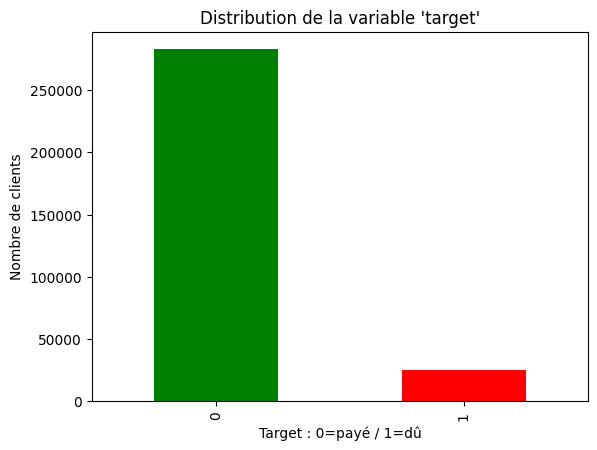

In [11]:
data_train['TARGET'].value_counts().plot(kind='bar', title="Distribution de la variable \'target'", xlabel='Target : 0=payé / 1=dû', ylabel='Nombre de clients', color=['green', 'red'])

On observe un biais de représentativité de la classe 1.

Il faudra pondérer cette hétérogénéité de classe pour que le modèle en tienne compte.

### 2-3 Identification des valeurs aberrantes

In [12]:
data_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


Tentons d'identifier les features avec des valeurs aberrantes :

In [13]:
# days_birth : âge des clients
(data_train['DAYS_BIRTH']/-365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Les valeurs sont cohérentes, on pourra remplacer cette feature par l'âge réel

<Axes: title={'center': 'Distribution des âges des clients'}, xlabel='âge (ans)', ylabel='Nombre de clients'>

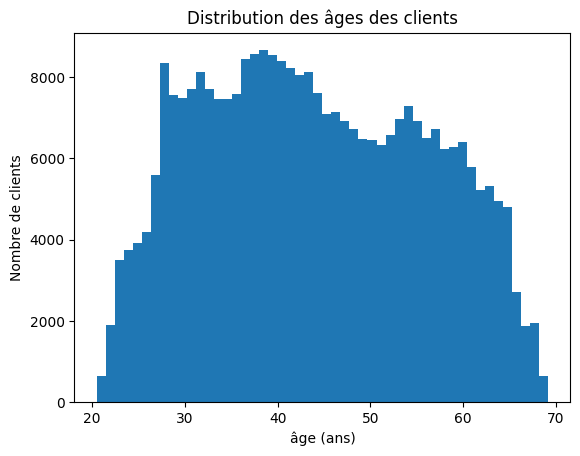

In [14]:
# distribution de l'âge des clients
(abs(data_train['DAYS_BIRTH']) / 365).plot.hist(bins=50, title='Distribution des âges des clients', xlabel='âge (ans)', ylabel='Nombre de clients')

In [15]:
# days_employed : ancienneté des clients
data_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Cette feature indique le nombre de jours depuis que le client travaille, cela exprime donc une durée négative d'autant plus grande que la personne travaille depuis longtemps.

Dans ce jeu de données, pour identifier les personnes sans emploi actuel on remplace cette feature par la valeur 365243 qui correspond à 1000 ans.

In [16]:
data_train.loc[data_train['DAYS_EMPLOYED'] > 300000, 'DAYS_EMPLOYED'].count()
unployed_clients = data_train.loc[data_train['DAYS_EMPLOYED'] > 300000, 'DAYS_EMPLOYED'].count()
print(f"Nombre de clients sans emploi ou retraités : {unployed_clients}, soit {unployed_clients / len(data_train) * 100:.2f}% du total des clients.")

Nombre de clients sans emploi ou retraités : 55374, soit 18.01% du total des clients.


Pour conserver cette caractéristique de la feature qui aura de l'importance pour l'interprétabilité et l'entrainement du modèle, on remplacera cette valeur numérique par NaN puis par '-1' pour que le modèle l'interprètre comme 'inconnu'

In [17]:
data_train['DAYS_EMPLOYED']=data_train['DAYS_EMPLOYED'].replace(365243, np.nan) # remplacer les valeurs aberrantes par Nan
data_train['DAYS_EMPLOYED']=data_train['DAYS_EMPLOYED'].fillna(-1) # indique 'inconnu' pour les clients sans emploi ou retraités

<Axes: title={'center': "Distribution des clients selon leur ancienneté d'emploi"}, xlabel="années d'ancienneté", ylabel='Nombre de clients'>

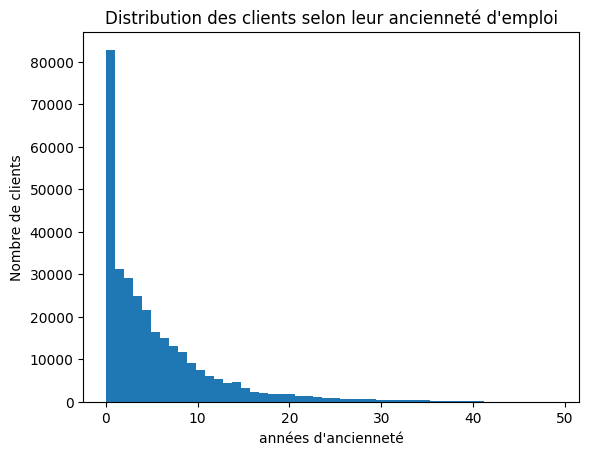

In [18]:
(data_train['DAYS_EMPLOYED']/-365).plot.hist(bins=50, title='Distribution des clients selon leur ancienneté d\'emploi', xlabel='années d\'ancienneté', ylabel='Nombre de clients')

### 2-4 Identification des valeurs manquantes

In [19]:
# fonction pour identifier les valeurs manquantes
def missing_values_table(df):
    mis_val = df.isnull().sum() # compte le nombre de valeurs manquantes
    mis_val_percent = 100 * df.isnull().sum() / len(df) # pourcentage de valeurs manquantes
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1) # concatène les deux séries
    mis_val_table_ren_columns = mis_val_table.rename(columns={0: 'Missing Values', 1: '% of Total Values'}) # renomme les colonnes
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:, 0] != 0].sort_values('% of Total Values', ascending=False).round(1) # trie par pourcentage de valeurs manquantes
    print("There are " + str(mis_val_table_ren_columns.shape[0]) + " columns with missing values.")
    
    return mis_val_table_ren_columns

In [20]:
missing_values = missing_values_table(data_train)
missing_values

There are 67 columns with missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_MODE,214865,69.9
COMMONAREA_AVG,214865,69.9
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_MEDI,213514,69.4
...,...,...
EXT_SOURCE_2,660,0.2
AMT_GOODS_PRICE,278,0.1
AMT_ANNUITY,12,0.0
CNT_FAM_MEMBERS,2,0.0


Afin de pouvoir entrainer les modèles de ML, il ne faut pas de valeurs manquantes, il faudra donc soit les remplacer (imputation) soit les supprimer. 

### 2-5 Analyse des corrélations

In [21]:
col_num = data_train.select_dtypes(include=['float64', 'int64'])

On va s'intéresser spécifiquement aux corrélations avec la feature d'intérêt 'target'

In [22]:
corr = col_num.corr()['TARGET'].sort_values(ascending=False)

In [23]:
corr_pos = corr.head(10)  # corrélations négatives
corr_neg = corr.tail(10)  # corrélations positives

In [24]:
corr_pos

TARGET                         1.000000
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_EMPLOYED                  0.046063
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_LIVE_CITY         0.044395
Name: TARGET, dtype: float64

In [25]:
corr_neg

ELEVATORS_MEDI               -0.033863
ELEVATORS_AVG                -0.034199
REGION_POPULATION_RELATIVE   -0.037227
AMT_GOODS_PRICE              -0.039645
FLOORSMAX_MODE               -0.043226
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_AVG                -0.044003
EXT_SOURCE_1                 -0.155317
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_3                 -0.178919
Name: TARGET, dtype: float64

De manière logique, on retrouve les features les plus prédictives sur 'target' avec :

- l'âge des clients

- la durée de l'emploi

- les sources externes qui correspondent à des scores de solvabilité des clients liés à des remboursements de crédits passés ou dans d'autre établissements

In [26]:
major_corr = data_train[['TARGET', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].corr()

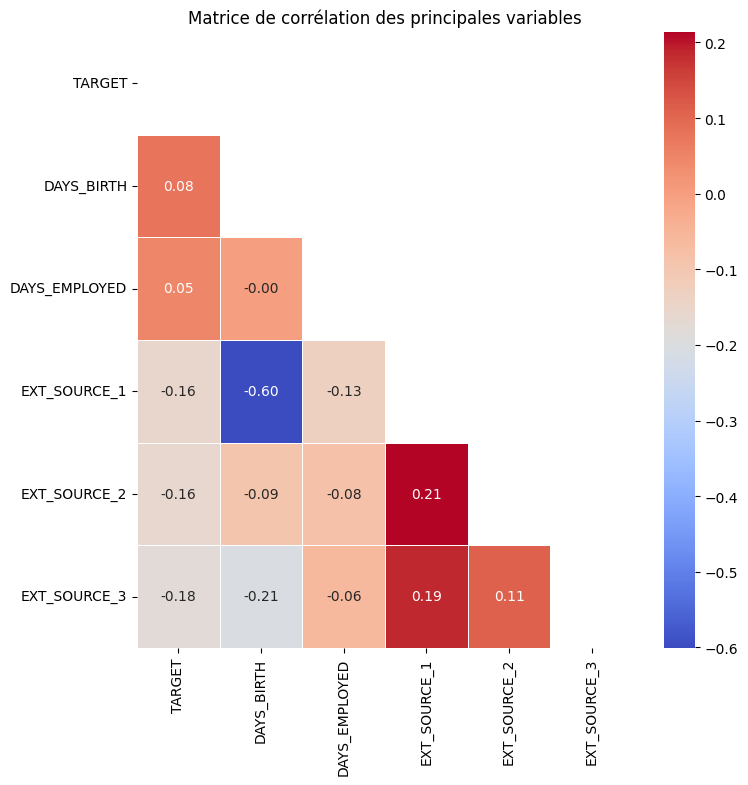

In [27]:
mask = np.triu(np.ones_like(major_corr, dtype=bool))
plt.figure(figsize=(8, 8))
sns.heatmap(major_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, mask=mask)
plt.title('Matrice de corrélation des principales variables')
plt.show()

Les valeurs des coeff de Pearson restent faibles, cependant, on constate des corrélations plus fortes avec les EXT_SOURCES.

Ces features auront de l'influence sur la précision de prédiction, il est nécessaire de ne pas avoir de valeurs manquantes pour que le modèle les utilise.

In [28]:
print(data_train['DAYS_BIRTH'].isna().sum(), "valeurs manquantes dans la colonne 'DAYS_BIRTH' \n",
      data_train['DAYS_EMPLOYED'].isna().sum(), "valeurs manquantes dans la colonne 'DAYS_EMPLOYED' \n",
      data_train['EXT_SOURCE_1'].isna().sum(), "valeurs manquantes dans la colonne 'EXT_SOURCE_1' \n",
      data_train['EXT_SOURCE_2'].isna().sum(), "valeurs manquantes dans la colonne 'EXT_SOURCE_2' \n",
      data_train['EXT_SOURCE_3'].isna().sum(), "valeurs manquantes dans la colonne 'EXT_SOURCE_3'")

0 valeurs manquantes dans la colonne 'DAYS_BIRTH' 
 0 valeurs manquantes dans la colonne 'DAYS_EMPLOYED' 
 173378 valeurs manquantes dans la colonne 'EXT_SOURCE_1' 
 660 valeurs manquantes dans la colonne 'EXT_SOURCE_2' 
 60965 valeurs manquantes dans la colonne 'EXT_SOURCE_3'


In [29]:
moy_days_birth = data_train['DAYS_BIRTH'].mean()
med_days_birth = data_train['DAYS_BIRTH'].median()      
moy_days_employed = data_train['DAYS_EMPLOYED'].mean()
med_days_employed = data_train['DAYS_EMPLOYED'].median()

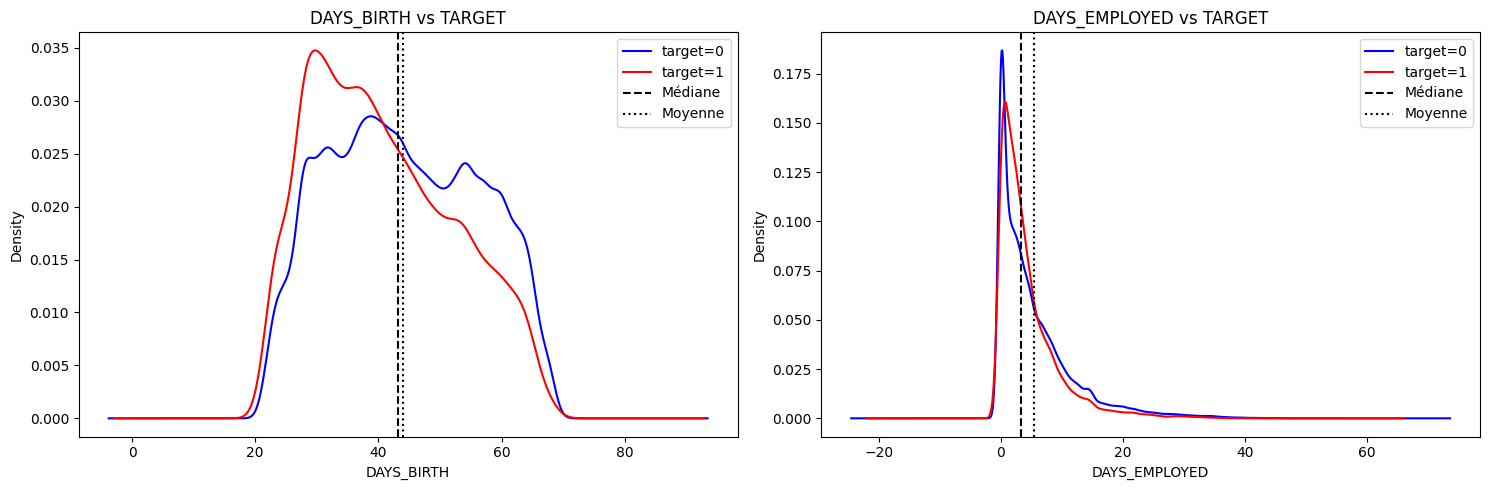

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

data_train.loc[data_train['TARGET'] == 0, 'DAYS_BIRTH'].div(-365).plot(kind='density', color='blue', label='target=0', ax=axs[0])
data_train.loc[data_train['TARGET'] == 1, 'DAYS_BIRTH'].div(-365).plot(kind='density', color='red', label='target=1', ax=axs[0])
axs[0].axvline(med_days_birth/-365, color='black', linestyle='--', label='Médiane')
axs[0].axvline(moy_days_birth/-365, color='black', linestyle=':', label='Moyenne')
axs[0].set_title('DAYS_BIRTH vs TARGET')
axs[0].set_xlabel('DAYS_BIRTH')
data_train.loc[data_train['TARGET'] == 0, 'DAYS_EMPLOYED'].div(-365).plot(kind='density', color='blue', label='target=0', ax=axs[1])
data_train.loc[data_train['TARGET'] == 1, 'DAYS_EMPLOYED'].div(-365).plot(kind='density', color='red', label='target=1', ax=axs[1])
axs[1].axvline(med_days_employed/-365, color='black', linestyle='--', label='Médiane')
axs[1].axvline(moy_days_employed/-365, color='black', linestyle=':', label='Moyenne')
axs[1].set_title('DAYS_EMPLOYED vs TARGET')
axs[1].set_xlabel('DAYS_EMPLOYED')
axs[0].legend()
axs[1].legend()
plt.tight_layout()
plt.show()


On peut constater une tendance des jeunes clients à moins bien rembourser leurs prêts

In [31]:
data_train['DAYS_BIRTH'].isnull().sum(), data_train['DAYS_EMPLOYED'].isnull().sum()

(np.int64(0), np.int64(0))

Pour l'interprétabilité on changera la variable days_birth par l'âge en années

In [32]:
data_train['DAYS_BIRTH'] = data_train['DAYS_BIRTH']/-365  # transformer les jours en années

In [33]:
bins=[20,25,30,35,40,45,50,55,60,65,70]
labels=['25-25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-55', '55-60', '60-65', '65-70']
data_train['AGE_GROUP'] = pd.cut(data_train['DAYS_BIRTH'], bins=bins, labels=labels, right=False)

In [34]:
counts = data_train.loc[data_train['TARGET']==1]['AGE_GROUP'].value_counts()

In [35]:
counts

AGE_GROUP
30-35    4057
35-40    3828
25-30    3659
40-45    3255
45-50    2605
50-55    2341
55-60    1832
25-25    1496
60-65    1450
65-70     302
Name: count, dtype: int64

C:\Users\Sophi\AppData\Local\Temp\ipykernel_5228\2785647614.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette='viridis')


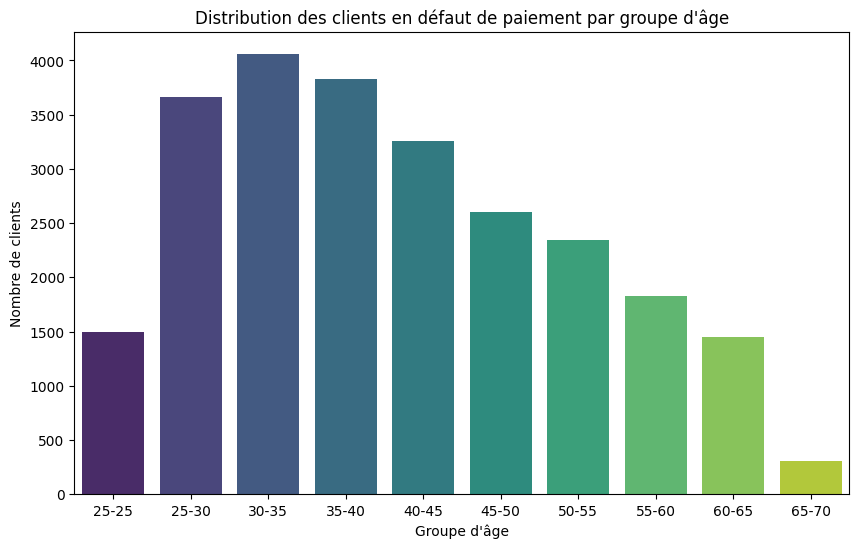

In [36]:
plt.figure(figsize=(10, 6))
sns.barplot(x=counts.index, y=counts.values, palette='viridis')
plt.title('Distribution des clients en défaut de paiement par groupe d\'âge')
plt.xlabel('Groupe d\'âge')
plt.ylabel('Nombre de clients')
plt.show()

Il semble effectivement y avoir plus de défaut de paiement chez les moins de 45 ans

In [37]:
(data_train['DAYS_EMPLOYED']/-365).describe()

count    307511.000000
mean          5.356242
std           6.320319
min          -0.000000
25%           0.791781
50%           3.323288
75%           7.561644
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

On modifira la valeur négative en valeur annuelle positive pour l'interprétabilité

In [38]:
data_train['DAYS_EMPLOYED']=data_train['DAYS_EMPLOYED']/-365

In [39]:
data_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].describe()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
count,134133.000000,3.068510e+05,246546.000000
mean,0.502130,5.143927e-01,0.510853
std,0.211062,1.910602e-01,0.194844
min,0.014568,8.173617e-08,0.000527
25%,0.334007,3.924574e-01,0.370650
50%,0.505998,5.659614e-01,0.535276
75%,0.675053,6.636171e-01,0.669057
max,0.962693,8.549997e-01,0.896010


Les scores des sources externes sont des valeurs normalisées, on a un certain nombre de valeurs manquantes dans chacune de ces catégories. On peut voir pour les imputer par une valeur de tendance centrale.

Regardons leurs distributions.

In [40]:
moy_ext_source_1 = data_train['EXT_SOURCE_1'].mean()
moy_ext_source_2 = data_train['EXT_SOURCE_2'].mean()    
moy_ext_source_3 = data_train['EXT_SOURCE_3'].mean()
med_ext_source_1 = data_train['EXT_SOURCE_1'].median()
med_ext_source_2 = data_train['EXT_SOURCE_2'].median()  
med_ext_source_3 = data_train['EXT_SOURCE_3'].median()

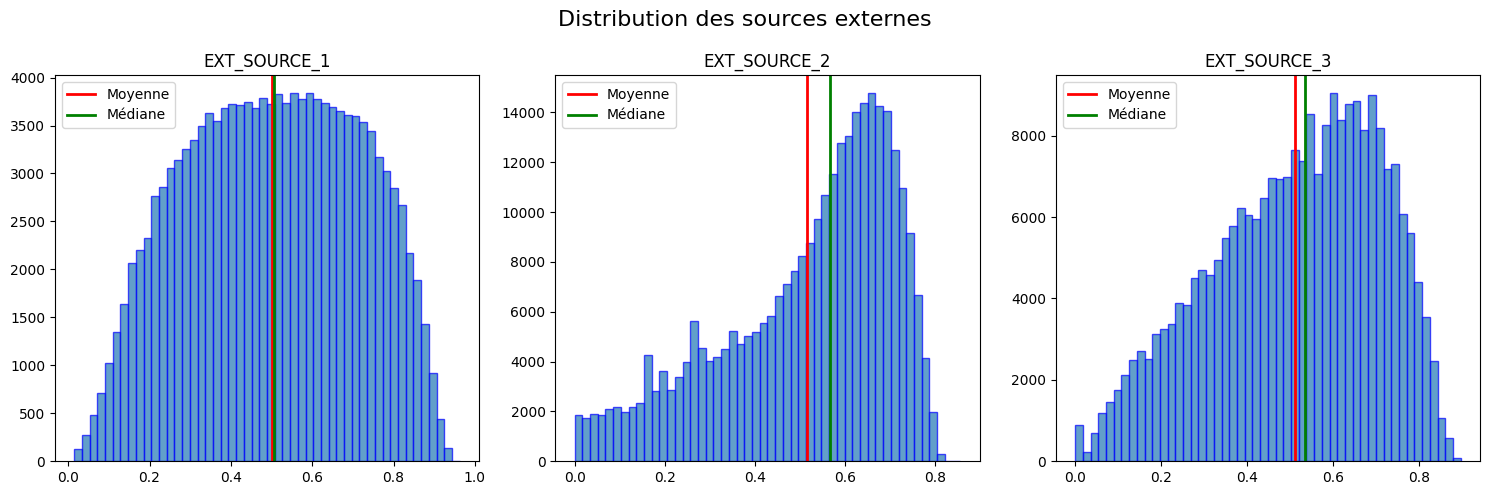

In [41]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# source_1
axs[0].set_title('EXT_SOURCE_1')
axs[0].hist(data_train['EXT_SOURCE_1'], bins=50, edgecolor='blue', alpha=0.7)
axs[0].axvline(moy_ext_source_1, label='Moyenne', color='red', linewidth=2)
axs[0].axvline(med_ext_source_1, label='Médiane', color='green', linewidth=2)
axs[0].legend()

# source_2
axs[1].set_title('EXT_SOURCE_2')
axs[1].hist(data_train['EXT_SOURCE_2'], bins=50, edgecolor='blue', alpha=0.7)
axs[1].axvline(moy_ext_source_2, label='Moyenne', color='red', linewidth=2)
axs[1].axvline(med_ext_source_2, label='Médiane', color='green', linewidth=2)
axs[1].legend()

# source_3
axs[2].set_title('EXT_SOURCE_3')
axs[2].hist(data_train['EXT_SOURCE_3'], bins=50, edgecolor='blue', alpha=0.7)
axs[2].axvline(moy_ext_source_3, label='Moyenne', color='red', linewidth=2)
axs[2].axvline(med_ext_source_3, label='Médiane', color='green', linewidth=2)
axs[2].legend() 

plt.tight_layout()
plt.suptitle('Distribution des sources externes', fontsize=16)
plt.subplots_adjust(top=0.85)  # Ajuste l'espace pour le titre
plt.show()

On va imputer les valeurs manquantes par la médiane

In [42]:
data_train['EXT_SOURCE_1'].fillna(med_ext_source_1, inplace=True)
data_train['EXT_SOURCE_2'].fillna(med_ext_source_2, inplace=True)
data_train['EXT_SOURCE_3'].fillna(med_ext_source_3, inplace=True)

C:\Users\Sophi\AppData\Local\Temp\ipykernel_5228\1579817078.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_train['EXT_SOURCE_1'].fillna(med_ext_source_1, inplace=True)
C:\Users\Sophi\AppData\Local\Temp\ipykernel_5228\1579817078.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

Regardons la distributions de ces features suivant la target

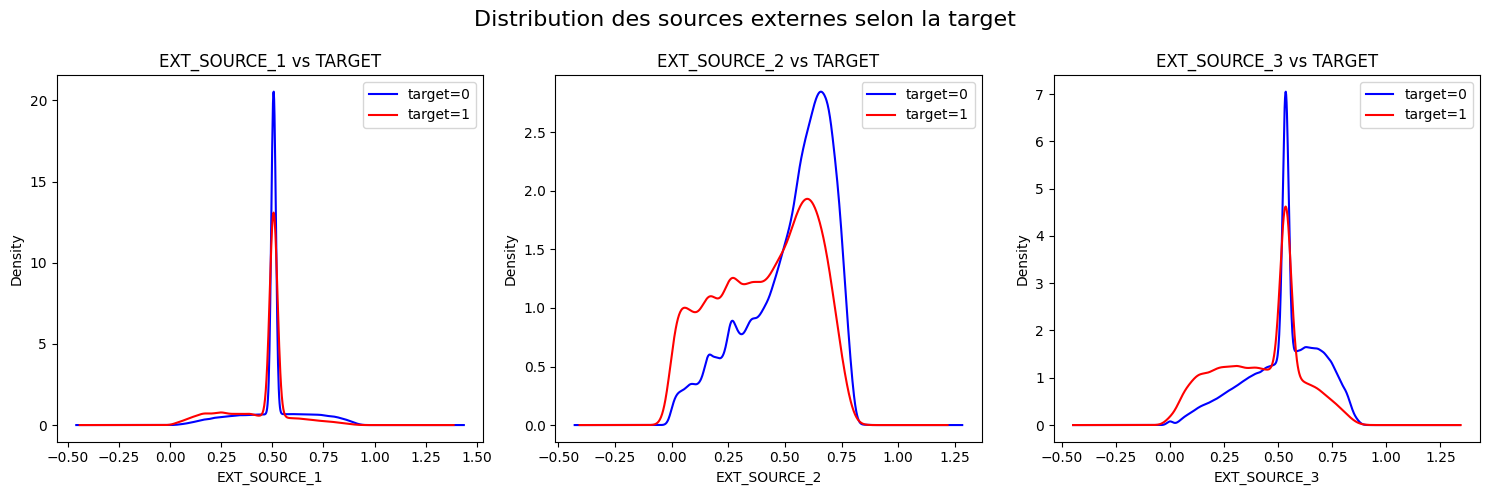

In [43]:
fig, axs = plt.subplots(1,3, figsize=(15, 5))
                        
data_train.loc[data_train['TARGET'] == 0, 'EXT_SOURCE_1'].plot(kind='density', color='blue', label='target=0', ax=axs[0])
data_train.loc[data_train['TARGET'] == 1, 'EXT_SOURCE_1'].plot(kind='density', color='red', label='target=1', ax=axs[0])
data_train.loc[data_train['TARGET'] == 0, 'EXT_SOURCE_2'].plot(kind='density', color='blue', label='target=0', ax=axs[1])
data_train.loc[data_train['TARGET'] == 1, 'EXT_SOURCE_2'].plot(kind='density', color='red', label='target=1', ax=axs[1])
data_train.loc[data_train['TARGET'] == 0, 'EXT_SOURCE_3'].plot(kind='density', color='blue', label='target=0', ax=axs[2])
data_train.loc[data_train['TARGET'] == 1, 'EXT_SOURCE_3'].plot(kind='density', color='red', label='target=1', ax=axs[2])

plt.suptitle('Distribution des sources externes selon la target', fontsize=16)
axs[0].set_title('EXT_SOURCE_1 vs TARGET')
axs[1].set_title('EXT_SOURCE_2 vs TARGET')
axs[2].set_title('EXT_SOURCE_3 vs TARGET')
axs[0].set_xlabel('EXT_SOURCE_1')
axs[1].set_xlabel('EXT_SOURCE_2')
axs[2].set_xlabel('EXT_SOURCE_3')
axs[0].legend()
axs[1].legend()
axs[2].legend()
plt.tight_layout()
plt.subplots_adjust(top=0.85)  
plt.show()



Le scoring des sources externes 2 et 3 semblent avoir une valeur prédictive sur la solvabilité des clients, à vérifier avec un test statistique

Test statistique entre variable continue normalisée et n'ayant pas une distribution gaussienne et une feature discrète binaire / catégorielle = test ANOVA

In [44]:
import pingouin as pg

In [45]:
pg.normality(data_train['EXT_SOURCE_2'], method='normaltest')

,W,pval,normal
EXT_SOURCE_2,26651.329907,0.0,False


On doit avoir recours à un test non-paramétrique

définissons nos deux features

In [46]:
X0 = data_train.loc[data_train["TARGET"]==0, 'EXT_SOURCE_2']
X1 = data_train.loc[data_train["TARGET"]==1, 'EXT_SOURCE_2']

In [47]:
from pingouin import kruskal

In [48]:
k_result = kruskal(data=data_train, dv='EXT_SOURCE_2', between='TARGET')
print(k_result)

         Source  ddof1            H  p-unc
Kruskal  TARGET      1  6657.087067    0.0


In [49]:
from scipy import stats
p_val = stats.mannwhitneyu(X0, X1) # test de Mann-Whitney
print(p_val)

MannwhitneyuResult(statistic=np.float64(4602996113.5), pvalue=np.float64(0.0))


On rejette l'hypothèse nulle selon laquelle les deux variables sont indépendantes, autrement dit, on a bien une corrélation

### 2-6 Encodage des valeurs catégorielles

Identifions le type des données de chacune des colonnes afin de savoir s'il sera nécessaire d'encoder certaines features et avec quel type d'encodeur

In [50]:
data_train.dtypes.value_counts()

float64     67
int64       39
object      16
category     1
Name: count, dtype: int64

On a 16 features catégorielles.

Les modèles de ML ne peuvent traiter que des features numériques, il nous faut donc encoder, c'est à dire numériser ces valeurs catégorielles.

Plusieurs types d'encodeurs existent, il s'agit d'utiliser les mieux adaptés pour coller à la représentativité des données.

In [51]:
data_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Pour les features ayant deux valeurs catégorielles possibles, nous choisirons de les encoder avec un label encodeur qui permet d'assigner un entier à chacune des valeurs catégorielles uniques.

Pour les features ayant plus de deux valeurs possibles, nous choisirons un one-hot-encodeur qui a l'avantage de ne pas induire de classification ordinale dans l'attribution des valeurs numériques. Il présente néanmoins l'inconvénient d'augmenter considérablement le nombre de features et donc de nécessité au besoin de recourir à une réduction de dimensionnalité, à peser avec le fait de perdre implicitement de l'information.

In [52]:
# définition des deux types d'encodeurs
# LabelEncoder pour les variables catégorielles avec deux valeurs possibles
label_encoder = LabelEncoder()
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
# Paramètre handle_unknown='use_encoded_value' permet d’éviter des erreurs avec des catégories inédites dans les données de test.

# OneHotEncoder pour les variables catégorielles avec plus de deux valeurs possibles
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Paramètre handle_unknown='ignore' permet d’éviter des erreurs avec des catégories inédites dans les données de test.
# Retourne un array dense avec sparse_output=False (et non une matrice creuse) pour faciliter la manipulation des données.

In [53]:
# on va créer un pipeline pour appliquer les encodeurs
from sklearn.compose import ColumnTransformer

Afin d'avoir une cohérence entre les données d'entrainement et de test pour que le modèle entrainé puisse prédire sur les données de test, il faudra appliquer les mêmes transformations sur les deux jeux de données.

In [54]:
# on enlève la feature 'target' du dataset d'entraînement
data_train_copy = data_train.copy()
x_train = data_train_copy.drop(columns=['TARGET','AGE_GROUP'])
y_train = data_train_copy['TARGET']

x_test = data_test.copy()

In [55]:
# définissons les features catégorielles binaires des autres
cat_features = x_train.select_dtypes(include=['object']).columns
binary_features = [col for col in cat_features if x_train[col].nunique() == 2]
multi_features = [col for col in cat_features if x_train[col].nunique() > 2]

In [56]:
# pipeline de traitement des données
preprocessor = ColumnTransformer(
    transformers=[
        ('binary', ordinal_encoder, binary_features),  # pour les variables binaires
        ('multi', one_hot_encoder, multi_features)   # pour les variables avec plus de deux catégories
    ],
    remainder='passthrough'  # laisse les autres colonnes inchangées
)

In [57]:
# appliquer le préprocesseur aux données d'entraînement et de test
x_train_transformed = preprocessor.fit_transform(x_train)
x_test_transformed = preprocessor.transform(x_test)

On va rajouter le nom des colonnes

In [58]:
bin_cols =binary_features
multi_cols = preprocessor.named_transformers_['multi'].get_feature_names_out(multi_features)
other_cols = [col for col in x_train.columns if col not in cat_features]

In [59]:
# liste finale des colonnes
final_colums = list(bin_cols) + list(multi_cols) + list(other_cols)

In [60]:
# dataframes finales avec les colonnes renommées
x_train_final = pd.DataFrame(x_train_transformed, columns=final_colums)
x_test_final = pd.DataFrame(x_test_transformed, columns=final_colums)

In [61]:
print(x_train_transformed.shape, x_test_transformed.shape)

(307511, 246) (48744, 246)


In [62]:
x_train_final.dtypes.value_counts()

float64    246
Name: count, dtype: int64

On a bien nos deux dataframes avec uniquement des valeurs numériques et avec le même nombre de colonnes

In [63]:
x_train_final.shape

(307511, 246)

In [64]:
x_train_final.head()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,EMERGENCYSTATE_MODE,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,1.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Partie 2 : feature engineering

L'objectif ici sera d'ajouter les features clés des autres fichiers dans nos datasets de train et test afin que tous les paramètres clients soient pris en compte par le modèle.

On standadisera également les features clés et on établira des rapports économiques permettant de mieux capturer le profil client.

### 2-1 Standardisaton

On va créer des nouvelles features correspondant à des ratios des features, pour pouvoir comparer les clients sur des valeurs plus normalisées

In [65]:
# stabilité de l'employabilité des clients : plus le ratio est élevé, plus le client est stable dans son emploi
# ratio = jours d'emploi / jours de naissance
x_train_final['EMPLOYABILITY_STABILITY'] = x_train_final['DAYS_EMPLOYED'] / x_train_final['DAYS_BIRTH']
x_test_final['EMPLOYABILITY_STABILITY'] = x_test_final['DAYS_EMPLOYED'] / x_test_final['DAYS_BIRTH']

In [66]:
# ratio entre les revenus annuels des clients et le montant du crédit demandé
# plus le ratio est élevé, plus le client est solvable
# ratio = revenus annuels / montant du crédit
x_train_final['ANNUAL_INCOME_CREDIT_RATIO'] = x_train_final['AMT_INCOME_TOTAL'] / x_train_final['AMT_CREDIT']
x_test_final['ANNUAL_INCOME_CREDIT_RATIO'] = x_test_final['AMT_INCOME_TOTAL'] / x_test_final['AMT_CREDIT']

In [67]:
# ratio des revenus annuels en fonction de la composition du foyer : selon le nombre de personnes à charge,
# plus le ratio est élevé, plus le client est solvable
# ratio = revenus annuels / nombre de personnes à charge
x_train_final['ANNUAL_INCOME_DEPENDENCY_RATIO'] = x_train_final['AMT_INCOME_TOTAL'] / (x_train_final['CNT_FAM_MEMBERS'] + 1)  # +1 pour éviter la division par zéro
x_test_final['ANNUAL_INCOME_DEPENDENCY_RATIO'] = x_test_final['AMT_INCOME_TOTAL'] / (x_test_final['CNT_FAM_MEMBERS'] + 1) 

In [68]:
# taux d'endettement des clients : proportion du montant du crédit annuel par rapport au revenu annuel
# ratio = montant du crédit annuel / revenu annuel
x_train_final['DEBT_TO_INCOME_RATIO'] = x_train_final['AMT_ANNUITY'] / (x_train_final['AMT_INCOME_TOTAL']) 
x_test_final['DEBT_TO_INCOME_RATIO'] = x_test_final['AMT_ANNUITY'] / (x_test_final['AMT_INCOME_TOTAL'])

In [69]:
# vitesse de remboursement du crédit : proportion du montant du crédit annuel par rapport au montant du crédit demandé
# plus le ratio est élevé, plus le client rembourse rapidement son crédit
# ratio = montant du crédit annuel / montant du crédit demandé
x_train_final['REPAYMENT_SPEED'] = x_train_final['AMT_ANNUITY'] / (x_train_final['AMT_CREDIT'])
x_test_final['REPAYMENT_SPEED'] = x_test_final['AMT_ANNUITY'] / (x_test_final['AMT_CREDIT'])

### 2-2 Processing des fichiers annexes

On va récupérer le passif des clients en terme de remboursements de crédits, l'objectif sera d'avoir des features représentatives du comportement de remboursement des clients sur leurs emprunts précédents.

Ces fichiers donnent des informations par identification de demande de prêt, un client pouvant avoir plusieurs demandes de prêts par le passé.

workflow :

1- lecture du fichier

2- encodage des variables catégorielles

3- regroupement des features par client

### 2-2-1 : Processing des fichiers bureau.csv et bureau_balance.csv

In [70]:
df_bureau = pd.read_csv('../DATA/DATA_source/bureau.csv')
df_bureau_balance = pd.read_csv('../DATA/DATA_source/bureau_balance.csv')

In [71]:
df_bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [72]:
df_bureau_balance.sample(20)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
5262771,6548307,-26,C
25758430,6336168,-30,0
20624810,5642146,-93,X
26529605,6528837,-88,0
1124008,5892660,-9,0
2270544,5205613,-79,X
15505549,5372831,-11,C
14510137,5669651,-70,X
10366703,6091533,-8,C
22650706,5980270,-36,C


1- On identifie des variables catégorielles que l'on va devoir encoder

2- on identifie une clé commune, SK_ID_BUREAU que l'on utilisera pour merger les deux DF

#### Encodage des features catégorielles

In [73]:
def one_hot_encoder(df, nan_as_category = True):
    """_summary_: Applique un encodage one-hot aux features catégorielles d'un DataFrame : 
                    transforme les variables catégorielles en valeur binaire (0/1).

    Args:
        df (_Dataframe_): _dataframe à processer_
        nan_as_category (bool, optional): _ ajoute une colonne spéciale pour les valeurs NaN :
            Si True (par défaut), crée la colonne et indique que la valeur NaN est une catégorie à part entière.
            Si False, les valeurs NaN seront traitées comme des valeurs manquantes et ne seront pas encodées.

    Returns:
        _type_: _le dataframe avec les features catégorielles encodées, 
                le nom des colonnes nouvellement créées après encodage_
    """
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [74]:
df_bureau_encoded, new_columns_bureau = one_hot_encoder(df_bureau, nan_as_category=True)
df_bureau_balance_encoded, new_columns_bureau_balance = one_hot_encoder(df_bureau_balance, nan_as_category=True)

In [75]:
new_columns_bureau_balance

['STATUS_0',
 'STATUS_1',
 'STATUS_2',
 'STATUS_3',
 'STATUS_4',
 'STATUS_5',
 'STATUS_C',
 'STATUS_X',
 'STATUS_nan']

On va regrouper les données par identifiant client

In [76]:
balance_agg_functions = {
    'MONTHS_BALANCE': ['min','max','size'],
    'STATUS_1' : 'mean', 
    'STATUS_2' : 'mean', 
    'STATUS_3' : 'mean', 
    'STATUS_4' : 'mean', 
    'STATUS_5' : 'mean', 
    'STATUS_C' : 'mean',
    'STATUS_X': 'mean'
}

In [77]:
# on aggrège les données par identifiant client
balance_agg = df_bureau_balance_encoded.groupby('SK_ID_BUREAU').agg(balance_agg_functions)

In [78]:
balance_agg.columns = ["BB_" + "_".join(col) for col in balance_agg.columns]
balance_agg.reset_index(inplace=True)

In [79]:
balance_agg

,SK_ID_BUREAU,BB_MONTHS_BALANCE_min,BB_MONTHS_BALANCE_max,BB_MONTHS_BALANCE_size,BB_STATUS_1_mean,BB_STATUS_2_mean,BB_STATUS_3_mean,BB_STATUS_4_mean,BB_STATUS_5_mean,BB_STATUS_C_mean,BB_STATUS_X_mean
0,5001709,-96,0,97,0.000000,0.0,0.0,0.0,0.0,0.886598,0.113402
1,5001710,-82,0,83,0.000000,0.0,0.0,0.0,0.0,0.578313,0.361446
2,5001711,-3,0,4,0.000000,0.0,0.0,0.0,0.0,0.000000,0.250000
3,5001712,-18,0,19,0.000000,0.0,0.0,0.0,0.0,0.473684,0.000000
4,5001713,-21,0,22,0.000000,0.0,0.0,0.0,0.0,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
817390,6842884,-47,0,48,0.000000,0.0,0.0,0.0,0.0,0.416667,0.395833
817391,6842885,-23,0,24,0.000000,0.0,0.0,0.0,0.5,0.000000,0.000000
817392,6842886,-32,0,33,0.000000,0.0,0.0,0.0,0.0,0.757576,0.000000
817393,6842887,-36,0,37,0.000000,0.0,0.0,0.0,0.0,0.837838,0.000000


#### Merge des deux DF

In [80]:
bureau_merged = pd.merge(df_bureau_encoded, balance_agg, on='SK_ID_BUREAU', how='left')

In [81]:
bureau_merged.drop(columns=['SK_ID_BUREAU'], inplace=True)  # on enlève la colonne SK_ID_BUREAU car elle n'est plus nécessaire

In [82]:
bureau_merged.columns

Index(['SK_ID_CURR', 'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE',
       'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE',
       'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT',
       'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY', 'CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Bad debt',
       'CREDIT_ACTIVE_Closed', 'CREDIT_ACTIVE_Sold', 'CREDIT_ACTIVE_nan',
       'CREDIT_CURRENCY_currency 1', 'CREDIT_CURRENCY_currency 2',
       'CREDIT_CURRENCY_currency 3', 'CREDIT_CURRENCY_currency 4',
       'CREDIT_CURRENCY_nan', 'CREDIT_TYPE_Another type of loan',
       'CREDIT_TYPE_Car loan', 'CREDIT_TYPE_Cash loan (non-earmarked)',
       'CREDIT_TYPE_Consumer credit', 'CREDIT_TYPE_Credit card',
       'CREDIT_TYPE_Interbank credit',
       'CREDIT_TYPE_Loan for business development',
       'CREDIT_TYPE_Loan for purchase of shares (margin lending)',
       'CREDIT_TYPE_Loan for the purchase of equipment',
       'CREDIT_TYP

Les colonnes issues de bureau_balance nous informer sur les données temporelles de remboursement de crédit :

- l'ancienneté du crédit et l'historique d'endettement du client (BB_MONTH)
- la proportion de retards de paiements, la stabilité des remboursements et le nbre de crédit actifs et clos (STATUS)

avec les moyennes de ces indicateurs aggrégés par client on identifie les proportions de crédits remboursés, des retards de paiement, de l'historique d'endettement

Sur les features de bureau, on identifie :

1- des données temporelles sur la durée du crédit, la durée de remboursement restante et les jours de retard: 'DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'CREDIT_DAY_OVERDUE','AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG'

2- on a des données chiffrées sur le niveau d'endettement des clients : 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT','AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY'

3- des données binaires sur la quantité de crédits en cours ou terminés :  'CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Bad debt',
'CREDIT_ACTIVE_Closed', 'CREDIT_ACTIVE_Sold', 'CREDIT_ACTIVE_nan'

on va aggréger ces données par client

In [83]:
agg_bureau_functions = {
    # données temporelles
    'DAYS_CREDIT': ['min', 'max', 'mean', 'std'], # ancienneté du crédit
    'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'], # durée du crédit
    'DAYS_ENDDATE_FACT': ['min', 'max', 'mean'], # durée de remboursement restante réelle
    'DAYS_CREDIT_UPDATE': ['mean'], # mise à jour de la date du crédit
    # données chiffrées
    'AMT_CREDIT_SUM': ['max', 'mean','sum'], # montant total du crédit
    'AMT_CREDIT_SUM_DEBT': ['sum', 'mean','max'], # montant total de la dette restante
    'AMT_CREDIT_SUM_LIMIT': ['sum', 'mean'], # montant total du plafond autorisé
    'AMT_CREDIT_SUM_OVERDUE': ['mean'], # montant en retard de paiement
    'AMT_ANNUITY' : ['max', 'mean'], # montant de l'annuité du crédit
    # données sur les retards de paiement
    'CREDIT_DAY_OVERDUE' : ['max', 'mean'], # proportion de jours de retard
    'CNT_CREDIT_PROLONG' : ['sum', 'mean','max'], # nbre de prolongation de crédit
    # données binaires 
    'CREDIT_ACTIVE_Active': ['mean'], # proportion de crédits actifs
    'CREDIT_ACTIVE_Bad debt': ['mean'], # proportion de crédits en défaut de paiement
    'CREDIT_ACTIVE_Closed': ['mean'], # proportion de crédits remboursés
}

In [84]:
df_agg = bureau_merged.groupby('SK_ID_CURR').agg(agg_bureau_functions)

In [85]:
df_agg.columns = ['_'.join(col) for col in df_agg.columns]
df_agg.reset_index(inplace=True)

In [86]:
df_agg.columns

Index(['SK_ID_CURR', 'DAYS_CREDIT_min', 'DAYS_CREDIT_max', 'DAYS_CREDIT_mean',
       'DAYS_CREDIT_std', 'DAYS_CREDIT_ENDDATE_min', 'DAYS_CREDIT_ENDDATE_max',
       'DAYS_CREDIT_ENDDATE_mean', 'DAYS_ENDDATE_FACT_min',
       'DAYS_ENDDATE_FACT_max', 'DAYS_ENDDATE_FACT_mean',
       'DAYS_CREDIT_UPDATE_mean', 'AMT_CREDIT_SUM_max', 'AMT_CREDIT_SUM_mean',
       'AMT_CREDIT_SUM_sum', 'AMT_CREDIT_SUM_DEBT_sum',
       'AMT_CREDIT_SUM_DEBT_mean', 'AMT_CREDIT_SUM_DEBT_max',
       'AMT_CREDIT_SUM_LIMIT_sum', 'AMT_CREDIT_SUM_LIMIT_mean',
       'AMT_CREDIT_SUM_OVERDUE_mean', 'AMT_ANNUITY_max', 'AMT_ANNUITY_mean',
       'CREDIT_DAY_OVERDUE_max', 'CREDIT_DAY_OVERDUE_mean',
       'CNT_CREDIT_PROLONG_sum', 'CNT_CREDIT_PROLONG_mean',
       'CNT_CREDIT_PROLONG_max', 'CREDIT_ACTIVE_Active_mean',
       'CREDIT_ACTIVE_Bad debt_mean', 'CREDIT_ACTIVE_Closed_mean'],
      dtype='object')

### 2-2-2 Processing du fichier previous_application.csv

In [87]:
prev_app = pd.read_csv('../DATA/DATA_source/previous_application.csv')

Le fichier previous_application.csv contient tout l'historique des demandes de crédit des clients précédent leur demande actuelle

In [88]:
prev_app.sample(15)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
1509363,1179001,236329,Cash loans,NaN,0.0,0.0,NaN,NaN,TUESDAY,19,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
1477010,1794392,321995,Consumer loans,5202.765,43150.5,44851.5,2340.0,43150.5,FRIDAY,11,...,Consumer electronics,12.0,high,POS household with interest,365243.0,-1946.0,-1616.0,-1676.0,-1674.0,0.0
878182,1465195,355456,Consumer loans,2263.275,22635.0,20371.5,2263.5,22635.0,SATURDAY,10,...,Consumer electronics,10.0,low_normal,POS household without interest,365243.0,-2672.0,-2402.0,-2402.0,-2394.0,0.0
346765,1617991,418162,Consumer loans,6397.425,31455.0,22455.0,9000.0,31455.0,MONDAY,14,...,Connectivity,4.0,high,POS mobile with interest,365243.0,-2869.0,-2779.0,-2779.0,-2681.0,0.0
635810,1312759,310299,Cash loans,12382.740,90000.0,109485.0,NaN,90000.0,THURSDAY,9,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-397.0,-67.0,-247.0,-242.0,1.0
1376369,2720491,279311,Revolving loans,9000.000,0.0,180000.0,NaN,NaN,MONDAY,15,...,XNA,0.0,XNA,Card X-Sell,NaN,NaN,NaN,NaN,NaN,NaN
824565,1262616,164676,Cash loans,5856.660,90000.0,102546.0,NaN,90000.0,SATURDAY,11,...,XNA,24.0,low_normal,Cash X-Sell: low,365243.0,-486.0,204.0,365243.0,365243.0,1.0
40930,1344813,455430,Cash loans,5392.530,54000.0,67950.0,NaN,54000.0,MONDAY,7,...,XNA,18.0,middle,Cash X-Sell: middle,NaN,NaN,NaN,NaN,NaN,NaN
33715,1221165,248752,Consumer loans,6061.140,110493.0,133830.0,0.0,110493.0,SATURDAY,10,...,Consumer electronics,24.0,low_action,POS household without interest,365243.0,-487.0,203.0,365243.0,365243.0,0.0
84457,2659279,302852,Consumer loans,6591.285,54900.0,49410.0,5490.0,54900.0,TUESDAY,9,...,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-2712.0,-2442.0,-2472.0,-2468.0,0.0


In [89]:
prev_encoded, cat_prev = one_hot_encoder(prev_app)

In [90]:
prev_encoded.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'AMT_ANNUITY', 'AMT_APPLICATION',
       'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'HOUR_APPR_PROCESS_START', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT',
       ...
       'PRODUCT_COMBINATION_Cash X-Sell: middle',
       'PRODUCT_COMBINATION_POS household with interest',
       'PRODUCT_COMBINATION_POS household without interest',
       'PRODUCT_COMBINATION_POS industry with interest',
       'PRODUCT_COMBINATION_POS industry without interest',
       'PRODUCT_COMBINATION_POS mobile with interest',
       'PRODUCT_COMBINATION_POS mobile without interest',
       'PRODUCT_COMBINATION_POS other with interest',
       'PRODUCT_COMBINATION_POS others without interest',
       'PRODUCT_COMBINATION_nan'],
      dtype='object', length=180)

In [91]:
# nettoyage des données
prev_encoded['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
prev_encoded['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
prev_encoded['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
prev_encoded['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
prev_encoded['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

C:\Users\Sophi\AppData\Local\Temp\ipykernel_5228\223127245.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  prev_encoded['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
C:\Users\Sophi\AppData\Local\Temp\ipykernel_5228\223127245.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

In [92]:
# ajout de ratios pour standardiser les données
# ratio = montant de la demande de crédit / montant du crédit accordé
# plus le ratio est élevé, plus le client est solvable
prev_encoded['APP_CREDIT_PERC'] = prev_encoded['AMT_APPLICATION'] / prev_encoded['AMT_CREDIT']

In [93]:
# plan d'aggrégation des données
agg_prev_functions = {
    # données chiffrées
    'AMT_ANNUITY': ['min', 'max', 'mean'], # montant de l'annuité du crédit
    'AMT_APPLICATION': ['min', 'max', 'mean'], # montant de la demande de crédit
    'AMT_CREDIT': ['min', 'max', 'mean'], # montant du crédit accordé
    'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'], # ratio entre le montant de la demande de crédit et le montant du crédit accordé
    'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'], # montant de l'apport personnel
    'AMT_GOODS_PRICE': ['min', 'max', 'mean'], # montant du bien acheté
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'], # taux d'apport personnel
    'CNT_PAYMENT': ['mean', 'sum'], # nombre de paiements prévus pour le crédit
    # données temporelles
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'], # heure de début du processus de demande de crédit
    'DAYS_DECISION': ['min', 'max', 'mean'], # délai de décision pour l'octroi du crédit

}

In [94]:
prev_agg = prev_encoded.groupby('SK_ID_CURR').agg(agg_prev_functions)
prev_agg.columns = ['_'.join(col) for col in prev_agg.columns]

### 2-3 Préprocessing du fichier POS_CASH_balance.csv

In [95]:
pos_cash = pd.read_csv('../DATA/DATA_source/POS_CASH_balance.csv')
pos_cash.sample(15)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
2717015,2777084,380296,-47,18.0,17.0,Active,0,0
5923008,1952513,148136,-70,12.0,0.0,Active,0,0
2081778,2305346,329876,-47,9.0,0.0,Active,0,0
6650287,1537324,110172,-5,24.0,17.0,Active,0,0
5471126,1398425,351691,-22,12.0,5.0,Active,0,0
7841538,1624618,362520,-33,4.0,0.0,Active,2923,0
660778,1898227,289803,-30,24.0,9.0,Active,0,0
2319660,1574726,125904,-9,12.0,12.0,Active,0,0
4902027,2243683,216323,-19,36.0,27.0,Active,0,0
4191435,2831856,441208,-52,6.0,5.0,Active,0,0


Ce fichier indique l'historique des cartes de crédits des clients 

In [96]:
pos_encoded, cat_pos = one_hot_encoder(pos_cash)

In [97]:
pos_agg_functions = {
    'MONTHS_BALANCE': ['min', 'max', 'size'], # mois relatif à la date actuelle
    'SK_DPD': ['max', 'mean'], # nombre de jours de retard de paiement
    'SK_DPD_DEF': ['max', 'mean'] # nombre de jours de retard considérés comme défaut par la banque
    }

In [98]:
pos_agg = pos_encoded.groupby('SK_ID_CURR').agg(pos_agg_functions)
pos_agg.columns = ['_'.join(col) for col in pos_agg.columns]

### 2-4 Préproccesing du fichier installments_payments.csv

In [99]:
ins_pay = pd.read_csv('../DATA/DATA_source/installments_payments.csv')
ins_pay_encoded, ins_cat = one_hot_encoder(ins_pay)
ins_pay_encoded.sample(5)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
6494386,1340066,274819,1.0,11,-2009.0,-1983.0,13114.980,13114.980
10019658,2759058,359170,1.0,10,-1726.0,-1767.0,11190.285,326.970
7301194,1607437,215484,1.0,5,-350.0,-362.0,8449.605,8449.605
9414,2245751,164142,1.0,5,-744.0,-749.0,16632.405,16632.405
4666630,1075695,219973,1.0,1,-1053.0,-1061.0,4008.690,4008.690


Ce fichier regroupe les informations relatives aux remboursements des échéances de prêts précédents : cela reflète le comportement de remboursement des clients par le passé.

AMT_INSTALMENT = montant prévu à payer pour l'échéance
AMT_PAYMENT = montant payé
DAYS_ENTRY_PAYMENT = jour d'échéance où le montant a été payé
DAYS_INSTALMENT = jour d'échéance prévu

donc pour savoir par client :

- quel est le montant de sa dette sur des prêts précédemment contractés et le pourcentage restant dû

- les retards de paiement éventuels 

In [100]:
ins_pay_encoded['PAYMENT_PERC'] = ins_pay_encoded['AMT_PAYMENT'] / ins_pay_encoded['AMT_INSTALMENT']
ins_pay_encoded['PAYMENT_DIFF'] = ins_pay_encoded['AMT_INSTALMENT'] - ins_pay_encoded['AMT_PAYMENT']
ins_pay_encoded["DAYS_LATE"] = ins_pay_encoded["DAYS_ENTRY_PAYMENT"] - ins_pay_encoded["DAYS_INSTALMENT"]

Définissons les aggrégations à réaliser pour regrouper les infos principales à regrouper par client

In [101]:
ins_agg = {
        'NUM_INSTALMENT_VERSION': ['nunique'], # version du plan de remboursement
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'], # ratio payé/dû
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'], # montant dû restant
        'AMT_INSTALMENT': ['max', 'mean', 'sum'], # montant à payer
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'], # montant payé
        'DAYS_LATE': ['max', 'mean', 'min', 'std'] # jour où l'échéance a été réellement payée, indique si retard
    }

In [102]:
ins_pay_agg = ins_pay_encoded.groupby("SK_ID_CURR").agg(ins_agg)

In [103]:
ins_pay_agg.columns = ["_".join(col).upper() for col in ins_pay_agg.columns]

### 2-2-5 Préprocessing du fichier credit_card_balance.csv

In [104]:
ccb = pd.read_csv('../DATA/DATA_source/credit_card_balance.csv')
ccb.sample(3)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
2502246,2353568,432186,-21,0.000,0,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
908501,1032625,152806,-6,286131.015,270000,17550.0,17550.0,0.0,0.0,12876.345,...,284209.515,284209.515,1.0,1,0.0,0.0,19.0,Active,0,0
2491815,2426793,228874,-30,0.000,135000,NaN,0.0,NaN,NaN,NaN,...,0.000,0.000,NaN,0,NaN,NaN,NaN,Active,0,0


Ce fichier représente l'historique d'utilisation du crédit des clients, il évalue l'usage réel du crédit accordé : on pourra savoir si le client utilise la totalité du crédit et s'il paye en avance ou en retard

On évaluera également le taux versé par le client par rapport au taux min demandé 

In [105]:
ccb_encoded, ccb_cat = one_hot_encoder(ccb)
ccb_encoded.sample(5)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,SK_DPD,SK_DPD_DEF,NAME_CONTRACT_STATUS_Active,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_Completed,NAME_CONTRACT_STATUS_Demand,NAME_CONTRACT_STATUS_Refused,NAME_CONTRACT_STATUS_Sent proposal,NAME_CONTRACT_STATUS_Signed,NAME_CONTRACT_STATUS_nan
1365851,2270984,180299,-9,0.000,45000,0.0,0.0,0.0,0.0,0.000,...,0,0,True,False,False,False,False,False,False,False
3311681,2258123,346367,-15,269076.600,270000,56250.0,56250.0,0.0,0.0,7479.045,...,0,0,True,False,False,False,False,False,False,False
3754167,1595654,437016,-47,25665.165,67500,0.0,0.0,0.0,0.0,3375.000,...,0,0,True,False,False,False,False,False,False,False
2989582,1647855,190797,-27,0.000,0,NaN,0.0,NaN,NaN,0.000,...,0,0,True,False,False,False,False,False,False,False
730774,2056547,262713,-16,0.000,0,0.0,0.0,0.0,0.0,0.000,...,0,0,True,False,False,False,False,False,False,False


In [106]:
ccb_encoded.drop(['SK_ID_PREV'], axis= 1, inplace = True)

In [107]:
ccb_encoded["CREDIT_UTILIZATION"] = ccb_encoded["AMT_BALANCE"] / ccb_encoded["AMT_CREDIT_LIMIT_ACTUAL"] # ratio d'uilisation du crédit

In [108]:
ccb_encoded["MIN_PAYMENT_RATIO"] = ccb_encoded["AMT_PAYMENT_CURRENT"] / (ccb_encoded["AMT_INST_MIN_REGULARITY"] + 1)

In [109]:
ccb_agg = {
    "CREDIT_UTILIZATION": ["mean", "max", "std"],
    "MIN_PAYMENT_RATIO": ["mean", "min"],
    "SK_DPD": ["mean", "max", "sum"],
    "SK_DPD_DEF": ["mean", "max", "sum"],
    "AMT_PAYMENT_CURRENT": ["mean", "sum"],
    "AMT_INST_MIN_REGULARITY": ["mean", "sum"],
    "CNT_DRAWINGS_CURRENT": ["mean", "max"],
    "CNT_DRAWINGS_ATM_CURRENT": ["mean", "max"]
}

In [110]:
credit_card_agg = ccb_encoded.groupby("SK_ID_CURR").agg(ccb_agg)

In [111]:
credit_card_agg.columns = ["CREDITCARD_" + "_".join(col).upper() for col in credit_card_agg.columns]
credit_card_agg = credit_card_agg.reset_index()

## 3- Fichiers processés finaux

On va désormais réunir tous ces éléments en un seul fichier train et un seul fichier test

In [112]:
x_train_final.shape

(307511, 251)

In [113]:
type(x_train_final)

pandas.core.frame.DataFrame

In [114]:
df_merged = x_train_final.merge(df_agg, on='SK_ID_CURR', how='left') \
                        .merge(prev_agg, on='SK_ID_CURR', how='left') \
                        .merge(pos_agg, on='SK_ID_CURR', how='left') \
                        .merge(ins_pay_agg, on='SK_ID_CURR', how='left') \
                        .merge(credit_card_agg, on='SK_ID_CURR', how='left')

In [115]:
df_merged.shape

(307511, 357)

In [116]:
df_test_merged = x_test_final.merge(df_agg, on='SK_ID_CURR', how='left') \
                            .merge(prev_agg, on='SK_ID_CURR', how='left') \
                            .merge(pos_agg, on='SK_ID_CURR', how='left') \
                            .merge(ins_pay_agg, on='SK_ID_CURR', how='left') \
                            .merge(credit_card_agg, on='SK_ID_CURR', how='left')

In [117]:
df_test_merged.shape

(48744, 357)

On a énormément de features, certaines sont inutiles ou redondantes, pour éviter l'overfitting, on va restreindre le nbre de features aux 100 majeures les plus corrélées à la target

In [118]:
# 1- on récupère la feature target dans le df_merged
df_merged['TARGET'] = y_train.values

In [119]:
df_merged.shape

(307511, 358)

In [120]:
# 2- on calcule les correlations en valeur absolue entre les features et la target pour sélectionner les plus pertinentes (pos et neg)
correlations = df_merged.corr()['TARGET'].abs().sort_values(ascending=False)

In [121]:
correlations

TARGET                                      1.000000
EXT_SOURCE_2                                0.160295
EXT_SOURCE_3                                0.155892
CREDITCARD_CREDIT_UTILIZATION_MEAN          0.135903
CREDITCARD_CNT_DRAWINGS_ATM_CURRENT_MEAN    0.107692
                                              ...   
PAYMENT_PERC_VAR                            0.000283
ORGANIZATION_TYPE_Legal Services            0.000236
FLAG_DOCUMENT_20                            0.000215
ORGANIZATION_TYPE_Advertising               0.000117
ORGANIZATION_TYPE_Industry: type 7          0.000094
Name: TARGET, Length: 358, dtype: float64

In [122]:
# 3- on ne conserve que les 100 features les plus corrélées avec la target
# On récupère les 100 features les plus corrélées (hors 'TARGET')
top_features = correlations.drop('TARGET').head(100).index.tolist()

In [123]:
# On crée les nouveaux DataFrames réduits
X_train_top = df_merged[top_features]
# Pour le test, on applique la même sélection de colonnes
X_test_top = df_test_merged[top_features]

In [124]:
# on ajoute la target au df d'entrainement
X_train_top['TARGET'] = df_merged['TARGET']

C:\Users\Sophi\AppData\Local\Temp\ipykernel_5228\2291428770.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_top['TARGET'] = df_merged['TARGET']


In [125]:
print(X_train_top.shape, X_test_top.shape)

(307511, 101) (48744, 100)


In [126]:
X_train_top.columns.tolist()

['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'CREDITCARD_CREDIT_UTILIZATION_MEAN',
 'CREDITCARD_CNT_DRAWINGS_ATM_CURRENT_MEAN',
 'CREDITCARD_CNT_DRAWINGS_CURRENT_MAX',
 'EXT_SOURCE_1',
 'CREDITCARD_CREDIT_UTILIZATION_MAX',
 'DAYS_CREDIT_mean',
 'CREDITCARD_CNT_DRAWINGS_CURRENT_MEAN',
 'CREDIT_ACTIVE_Closed_mean',
 'DAYS_BIRTH',
 'CREDIT_ACTIVE_Active_mean',
 'DAYS_CREDIT_min',
 'CREDITCARD_AMT_INST_MIN_REGULARITY_MEAN',
 'CREDITCARD_CREDIT_UTILIZATION_STD',
 'DAYS_CREDIT_UPDATE_mean',
 'CREDITCARD_CNT_DRAWINGS_ATM_CURRENT_MAX',
 'REGION_RATING_CLIENT_W_CITY',
 'REGION_RATING_CLIENT',
 'NAME_INCOME_TYPE_Working',
 'NAME_EDUCATION_TYPE_Higher education',
 'DAYS_ENDDATE_FACT_min',
 'MONTHS_BALANCE_min',
 'DAYS_LAST_PHONE_CHANGE',
 'CODE_GENDER_M',
 'CODE_GENDER_F',
 'DAYS_DECISION_min',
 'DAYS_ENDDATE_FACT_mean',
 'DAYS_ID_PUBLISH',
 'REG_CITY_NOT_WORK_CITY',
 'DAYS_CREDIT_std',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'DAYS_CREDIT_max',
 'DAYS_CREDIT_ENDDATE_mean',
 'DAYS_DECISION_me

In [127]:
X_train_top.to_csv('../DATA/DATA_cleaned/application_train_final.csv', index=False)
X_test_top.to_csv('../DATA/DATA_cleaned/application_test_final.csv', index=False)